# **Notebook 1: Logistic Regression + GRU**

In [1]:
# Install dependencies
!pip install pandas numpy scikit-learn tensorflow nltk matplotlib seaborn

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional
import re
import os
import joblib

In [10]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
# Set paths
train_path = '/content/drive/MyDrive/dataset-sm/train.csv'
val_path = '/content/drive/MyDrive/dataset-sm/validation.csv'
test_path = '/content/drive/MyDrive/dataset-sm/test.csv'

In [5]:
# Load datasets
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

# --- Step 1: Exploratory Data Analysis (EDA) ---

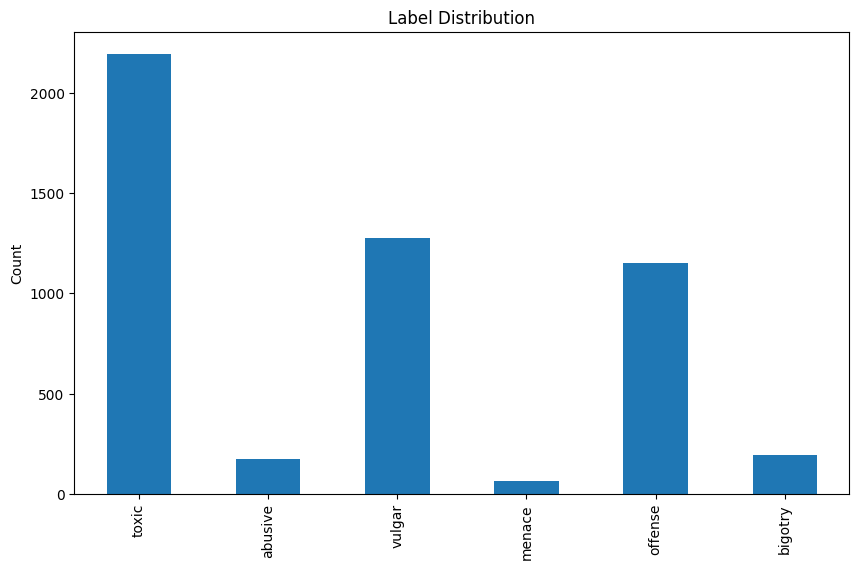

In [6]:
# Label distribution
labels = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']
plt.figure(figsize=(10, 6))
train_df[labels].sum().plot(kind='bar')
plt.title('Label Distribution')
plt.ylabel('Count')
plt.savefig('/content/drive/MyDrive/label_distribution.png')
plt.show()

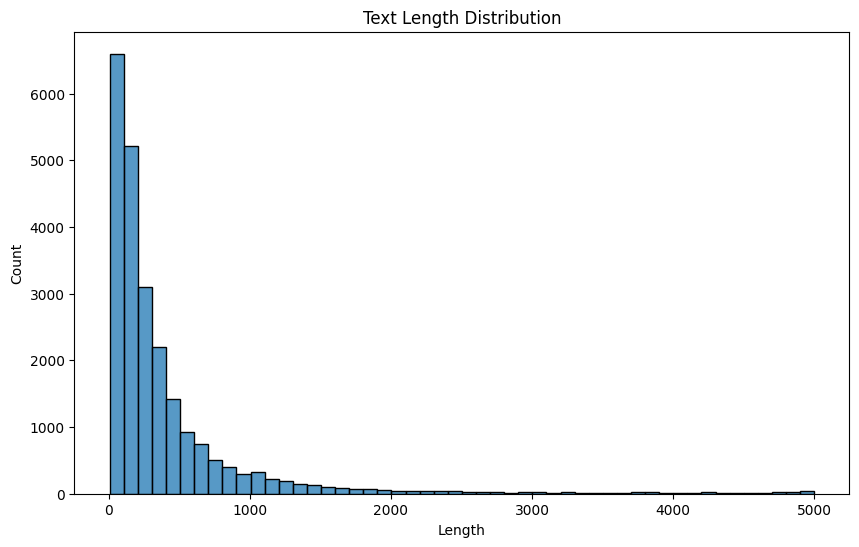

In [7]:
# Text length distribution
train_df['text_length'] = train_df['feedback_text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(train_df['text_length'], bins=50)
plt.title('Text Length Distribution')
plt.xlabel('Length')
plt.savefig('/content/drive/MyDrive/text_length.png')
plt.show()

In [8]:
# Check for missing values
print("Missing Values:\n", train_df.isnull().sum())

Missing Values:
 id               0
feedback_text    0
toxic            0
abusive          0
vulgar           0
menace           0
offense          0
bigotry          0
text_length      0
dtype: int64


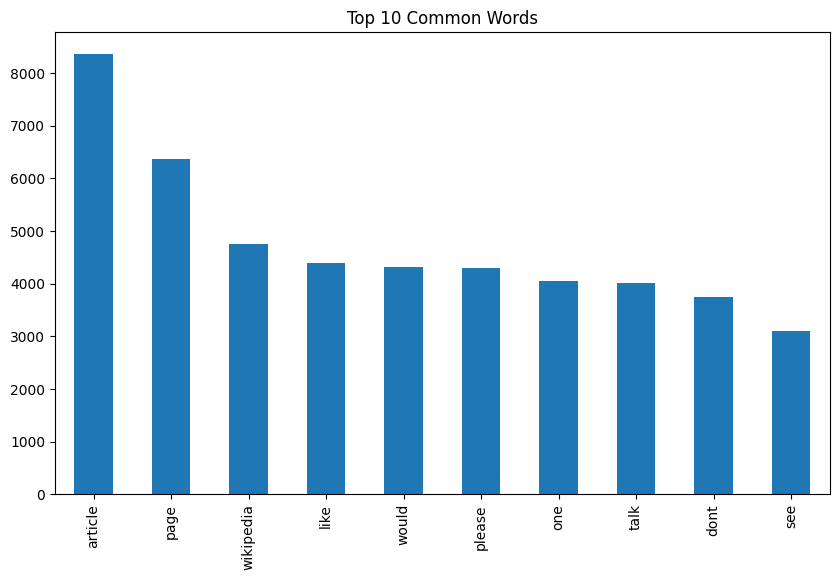

In [11]:
# Word frequency (top 10 words)
stop_words = set(stopwords.words('english'))
all_words = ' '.join(train_df['feedback_text']).lower()
all_words = re.sub(r'[^\w\s]', '', all_words)
words = word_tokenize(all_words)
words = [w for w in words if w not in stop_words]
freq = pd.Series(words).value_counts()[:10]
plt.figure(figsize=(10, 6))
freq.plot(kind='bar')
plt.title('Top 10 Common Words')
plt.savefig('/content/drive/MyDrive/word_freq.png')
plt.show()

# --- Step 2: Text Preprocessing ---

In [12]:
# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

In [13]:
# Apply preprocessing
train_df['processed_text'] = train_df['feedback_text'].apply(preprocess_text)
val_df['processed_text'] = val_df['feedback_text'].apply(preprocess_text)
test_df['processed_text'] = test_df['content'].apply(preprocess_text)

# --- Step 3: Logistic Regression ---

In [14]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(train_df['processed_text'])
X_val_tfidf = tfidf.transform(val_df['processed_text'])
X_test_tfidf = tfidf.transform(test_df['processed_text'])

y_train = train_df['toxic']
y_val = val_df['toxic']

In [15]:
# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [16]:
# Evaluate
y_pred_lr = lr_model.predict(X_val_tfidf)
print("Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_val, y_pred_lr):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_val, lr_model.predict_proba(X_val_tfidf)[:, 1]):.4f}")

Logistic Regression Metrics:
Accuracy: 0.8429
Precision: 1.0000
Recall: 0.0149
F1-Score: 0.0294
AUC-ROC: 0.5861


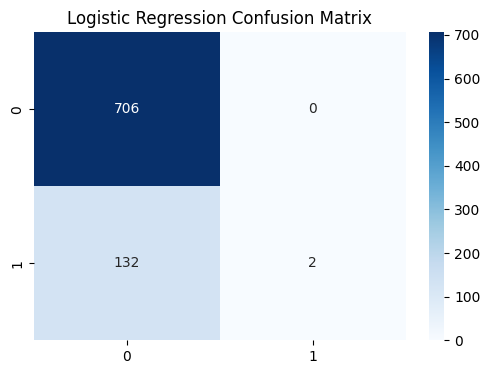

In [17]:
# Confusion Matrix
cm_lr = confusion_matrix(y_val, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.savefig('/content/drive/MyDrive/cm_lr.png')
plt.show()

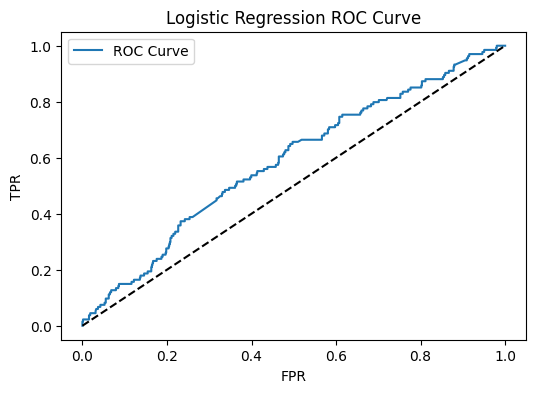

In [18]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_val, lr_model.predict_proba(X_val_tfidf)[:, 1])
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Logistic Regression ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.savefig('/content/drive/MyDrive/roc_lr.png')
plt.show()

# --- Step 4: GRU ---

In [19]:
# Tokenization for GRU
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_df['processed_text'])
X_train_seq = tokenizer.texts_to_sequences(train_df['processed_text'])
X_val_seq = tokenizer.texts_to_sequences(val_df['processed_text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['processed_text'])

In [20]:
# Padding
max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [21]:
# Build GRU model
gru_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_len),
    Bidirectional(GRU(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(GRU(32)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gru_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train GRU
history = gru_model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_val_pad, y_val), verbose=1)

Epoch 1/5
734/734 ━━━━━━━━━━━━━━━━━━━━ 203s 262ms/step - accuracy: 0.9269 - loss: 0.2476 - val_accuracy: 0.8393 - val_loss: 0.5582
Epoch 2/5
734/734 ━━━━━━━━━━━━━━━━━━━━ 203s 264ms/step - accuracy: 0.9608 - loss: 0.1082 - val_accuracy: 0.8393 - val_loss: 0.9363
Epoch 3/5
734/734 ━━━━━━━━━━━━━━━━━━━━ 202s 275ms/step - accuracy: 0.9722 - loss: 0.0767 - val_accuracy: 0.8333 - val_loss: 0.8849
Epoch 4/5
734/734 ━━━━━━━━━━━━━━━━━━━━ 252s 262ms/step - accuracy: 0.9824 - loss: 0.0498 - val_accuracy: 0.8357 - val_loss: 1.1559
Epoch 5/5
734/734 ━━━━━━━━━━━━━━━━━━━━ 203s 264ms/step - accuracy: 0.9861 - loss: 0.0386 - val_accuracy: 0.8333 - val_loss: 1.3478


In [23]:
# Evaluate
y_pred_gru = (gru_model.predict(X_val_pad) > 0.5).astype(int)
print("GRU Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_gru):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_gru):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_gru):.4f}")
print(f"F1-Score: {f1_score(y_val, y_pred_gru):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_val, gru_model.predict(X_val_pad)):.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step
GRU Metrics:
Accuracy: 0.8333
Precision: 0.3125
Recall: 0.0373
F1-Score: 0.0667
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
AUC-ROC: 0.4873


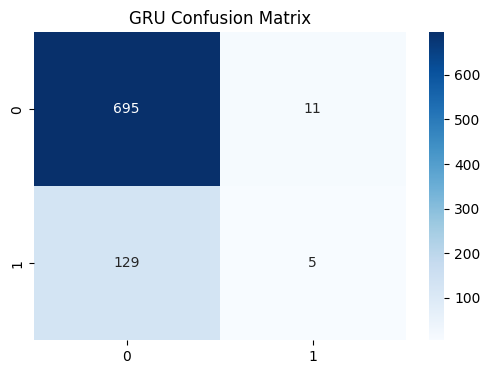

In [24]:
# Confusion Matrix
cm_gru = confusion_matrix(y_val, y_pred_gru)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues')
plt.title('GRU Confusion Matrix')
plt.savefig('/content/drive/MyDrive/cm_gru.png')
plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


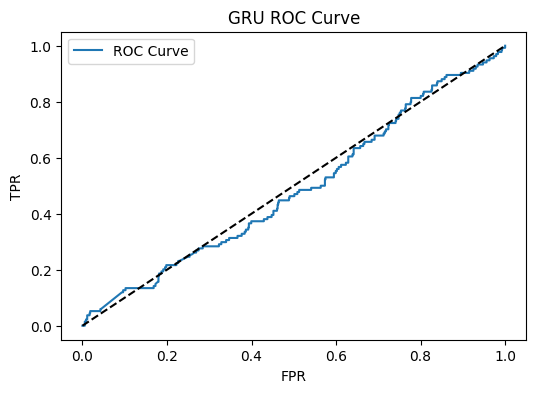

In [25]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_val, gru_model.predict(X_val_pad))
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('GRU ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.savefig('/content/drive/MyDrive/roc_gru.png')
plt.show()

# --- Step 5: Model Tuning (Logistic Regression) ---

In [26]:
param_grid = {'C': [0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=3)
grid.fit(X_train_tfidf, y_train)
print("Best Logistic Regression Params:", grid.best_params_)
best_lr = grid.best_estimator_
y_pred_best_lr = best_lr.predict(X_val_tfidf)
print("Tuned Logistic Regression F1-Score:", f1_score(y_val, y_pred_best_lr))

Best Logistic Regression Params: {'C': 10}
Tuned Logistic Regression F1-Score: 0.0425531914893617


# --- Step 6: Predictions on Test Data ---

In [27]:
# Logistic Regression predictions
test_pred_lr = best_lr.predict(X_test_tfidf)
submission_lr = pd.DataFrame({'id': test_df['id'], 'toxic': test_pred_lr})
submission_lr.to_csv('/content/drive/MyDrive/submission_lr.csv', index=False)

In [28]:
# GRU predictions
test_pred_gru = (gru_model.predict(X_test_pad) > 0.5).astype(int)
submission_gru = pd.DataFrame({'id': test_df['id'], 'toxic': test_pred_gru.flatten()})
submission_gru.to_csv('/content/drive/MyDrive/submission_gru.csv', index=False)

188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step


In [29]:
# Save Logistic Regression model
try:
    joblib.dump(best_lr, '/content/drive/MyDrive/lr_model.pkl')
    print("Logistic Regression model saved successfully!")
except NameError:
    print("Error: 'best_lr' not defined. Ensure Grid Search block ran successfully.")
    joblib.dump(lr_model, '/content/drive/MyDrive/lr_model.pkl')  # Fallback to untuned model

Logistic Regression model saved successfully!


In [30]:
# Save GRU model
gru_model.save('/content/drive/MyDrive/gru_model.h5')